In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/witrw-dataset/sample_submission.csv
/kaggle/input/witrw-dataset/train.csv
/kaggle/input/witrw-dataset/test.csv
/kaggle/input/who-is-the-real-winner/sample_submission.csv
/kaggle/input/who-is-the-real-winner/train.csv
/kaggle/input/who-is-the-real-winner/test.csv


In [2]:
train = pd.read_csv("/kaggle/input/witrw-dataset/train.csv")
test = pd.read_csv("/kaggle/input/witrw-dataset/test.csv")

In [3]:
train

,ID,Candidate,Constituency ∇,Party,Criminal Case,Total Assets,Liabilities,state,Education
0,0,M.K. Mohan,ANNA NAGAR,DMK,4,211 Crore+,2 Crore+,TAMIL NADU,8th Pass
1,1,Khatik Ramesh Prasad,KARERA (SC),BJP,0,1 Crore+,0,MADHYA PRADESH,12th Pass
2,2,Dr. Mantar Gowda,MADIKERI,INC,0,7 Crore+,22 Lac+,KARNATAKA,Post Graduate
3,3,Kundan Kumar,BEGUSARAI,BJP,0,9 Crore+,24 Lac+,BIHAR,Post Graduate
4,4,Swapan Majumder,BANGAON DAKSHIN (SC),BJP,2,2 Crore+,61 Lac+,WEST BENGAL,8th Pass
...,...,...,...,...,...,...,...,...,...
2054,2054,V. Sasi,CHIRAYINKEEZHU,CPI,1,61 Lac+,10 Lac+,KERALA,Graduate Professional
2055,2055,Pushkar Lal Dangi,MAVLI,INC,0,2 Crore+,8 Lac+,RAJASTHAN,10th Pass
2056,2056,Dr. Manju Shiwach,MODI NAGAR,BJP,0,13 Crore+,85 Lac+,UTTAR PRADESH,Graduate
2057,2057,Mansing Fattesingrao Naik,SHIRALA,NCP,1,25 Crore+,94 Lac+,MAHARASHTRA,12th Pass


In [4]:
# All imports here

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter 
from numpy import where

import imblearn
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SVMSMOTE

from sklearn.metrics import f1_score

## Preprocessing

In [6]:
def convert_to_numeric(value_str):
    value_str = str(value_str)
    value_str = value_str.strip()
    
    if 'Crore' in value_str:
        numeric_value = int(value_str.split()[0]) * 10000000
    elif 'Lac' in value_str:
        numeric_value = int(value_str.split()[0]) * 100000
    elif 'Thou' in value_str:
        numeric_value = int(value_str.split()[0]) * 1000
    elif 'Hund' in value_str:
        numeric_value = int(value_str.split()[0]) * 100
    else:
        numeric_value = int(value_str)
        
    return numeric_value

In [7]:
train['Total Assets'] = train['Total Assets'].apply(lambda x: convert_to_numeric(x))
train['Liabilities'] = train['Liabilities'].apply(lambda x: convert_to_numeric(x))

test['Total Assets'] = test['Total Assets'].apply(lambda x: convert_to_numeric(x))
test['Liabilities'] = test['Liabilities'].apply(lambda x: convert_to_numeric(x))

In [ ]:
train['A + L'] = train['Total Assets'] + train['Liabilities']

def remove_outliers_zscore(df, column, threshold=3):
    z_scores = np.abs((df[column] - df[column].mean()) / df[column].std())
    filtered_df = df[z_scores < threshold]
    return filtered_df

train = remove_outliers_zscore(train, 'A + L')

In [85]:
# X = train.drop(columns=['ID', 'Candidate', 'Education', 'Constituency ∇'])
X = train.drop(columns=['ID', 'Candidate', 'Education'])
y = train['Education']

X_testOG = test.drop(columns=['ID', 'Constituency ∇'])
X_testOG = test.drop(columns=['ID'])

In [86]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, stratify=y, shuffle=True)
X_train, y_train = X, y
X_test, y_test = X, y

In [9]:
print(X_train.head(5))

         Constituency ∇ Party  Criminal Case  Total Assets  Liabilities  \
0            ANNA NAGAR   DMK              4    2110000000     20000000   
1           KARERA (SC)   BJP              0      10000000            0   
2              MADIKERI   INC              0      70000000      2200000   
3             BEGUSARAI   BJP              0      90000000      2400000   
4  BANGAON DAKSHIN (SC)   BJP              2      20000000      6100000   

            state  
0      TAMIL NADU  
1  MADHYA PRADESH  
2       KARNATAKA  
3           BIHAR  
4     WEST BENGAL  


In [87]:
# categorical_cols = ['Party', 'Constituency ∇', 'state']
categorical_cols = ['Party', 'state']
numerical_cols = ['Criminal Case', 'Total Assets', 'Liabilities']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown = 'ignore', sparse_output=False), categorical_cols)])

# Fit and transform the preprocessing pipeline on training data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

In [88]:
print(len(X_train["Constituency ∇"].unique()))
print(len(X_train["Party"].unique()))
print(len(X_train["state"].unique()))

2037
23
28


In [12]:
print(X_train_preprocessed)
print(X_test_preprocessed)
print(X_train_preprocessed.shape)
print(X_test_preprocessed.shape)
pd.DataFrame(X_train_preprocessed)

[[ 0.46679808  4.05261459 -0.00776657 ...  0.          0.
   0.        ]
 [-0.37335686 -0.21457701 -0.10541735 ...  0.          0.
   0.        ]
 [-0.37335686 -0.09265725 -0.09467577 ...  0.          0.
   0.        ]
 ...
 [-0.37335686  0.02926251 -0.06391577 ...  1.          0.
   0.        ]
 [-0.16331812  0.27310203 -0.05952149 ...  0.          0.
   0.        ]
 [-0.37335686 -0.23266178 -0.10541735 ...  0.          0.
   0.        ]]
[[ 0.46679808  4.05261459 -0.00776657 ...  0.          0.
   0.        ]
 [-0.37335686 -0.21457701 -0.10541735 ...  0.          0.
   0.        ]
 [-0.37335686 -0.09265725 -0.09467577 ...  0.          0.
   0.        ]
 ...
 [-0.37335686  0.02926251 -0.06391577 ...  1.          0.
   0.        ]
 [-0.16331812  0.27310203 -0.05952149 ...  0.          0.
   0.        ]
 [-0.37335686 -0.23266178 -0.10541735 ...  0.          0.
   0.        ]]
(2059, 54)
(2059, 54)


,0,1,2,3,4,5,6,7,8,9,...,44,45,46,47,48,49,50,51,52,53
0,0.466798,4.052615,-0.007767,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,-0.373357,-0.214577,-0.105417,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.373357,-0.092657,-0.094676,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.373357,-0.052017,-0.093699,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.046721,-0.194257,-0.075634,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2054,-0.163318,-0.222502,-0.100535,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2055,-0.373357,-0.194257,-0.101511,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2056,-0.373357,0.029263,-0.063916,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2057,-0.163318,0.273102,-0.059521,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Model Selection and Training on given Dataset

In [13]:
model = RandomForestClassifier(n_estimators=100, random_state=33)
knn = KNeighborsClassifier(n_neighbors=10)
dt = DecisionTreeClassifier(max_depth=15, criterion='gini', splitter='best',)
sv = SVC(C = 7, kernel='rbf')

model.fit(X_train_preprocessed, y_train)
knn.fit(X_train_preprocessed, y_train)
dt.fit(X_train_preprocessed, y_train)
sv.fit(X_train_preprocessed, y_train)

# Model Evaluation
y1 = model.predict(X_test_preprocessed)
y2 = knn.predict(X_test_preprocessed)
y3 = dt.predict(X_test_preprocessed)
y4 = sv.predict(X_test_preprocessed)

ac1 = accuracy_score(y_test, y1)
ac2 = accuracy_score(y_test, y2)
ac3 = accuracy_score(y_test, y3)
ac4 = accuracy_score(y_test, y4)

print("ac1 : ", ac1)
print("ac2 : ", ac2)
print("ac3 : ", ac3)
print("ac4 : ", ac4)

ac1 :  0.9689169499757163
ac2 :  0.38173870811073335
ac3 :  0.5308402136959689
ac4 :  0.3778533268576979


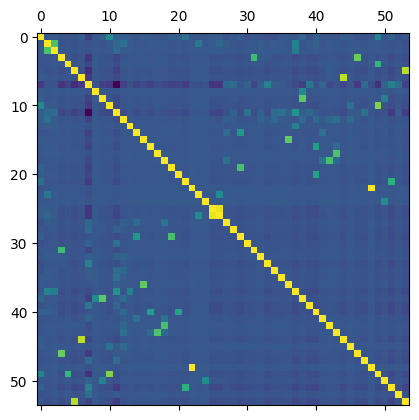

In [167]:
# Correlation matrix

Xtp = pd.DataFrame(X_train_preprocessed)
plt.matshow(Xtp.corr())
plt.show()

In [78]:
# To convert our result dataframe into csv

y1d = pd.DataFrame(y4)
y1d
y1d.to_csv('/kaggle/working/res1.csv',index=True)

array([[<Axes: title={'center': 'Criminal Case'}>,
        <Axes: title={'center': 'Total Assets'}>],
       [<Axes: title={'center': 'Liabilities'}>, <Axes: >]], dtype=object)

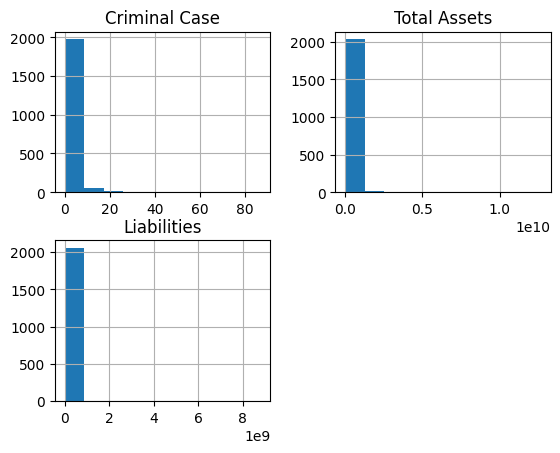

In [14]:
X.hist()

<Axes: >

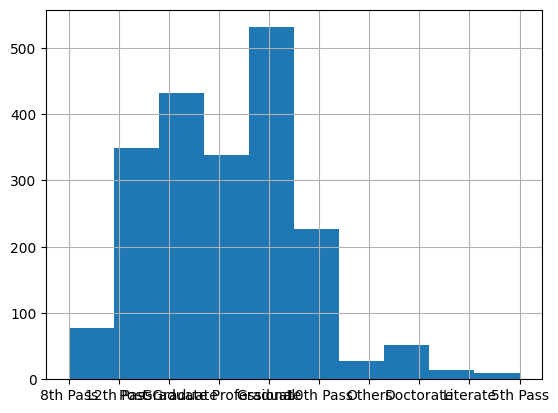

In [80]:
y.hist()

In [82]:
counter = Counter(y)
print(counter)

Counter({'Graduate': 531, 'Post Graduate': 432, '12th Pass': 349, 'Graduate Professional': 339, '10th Pass': 227, '8th Pass': 78, 'Doctorate': 52, 'Others': 28, 'Literate': 14, '5th Pass': 9})


# Data Augmentation

## Using ADASYN

Before sampling class distribution:- Counter({'Graduate': 531, 'Post Graduate': 432, '12th Pass': 349, 'Graduate Professional': 339, '10th Pass': 227, '8th Pass': 78, 'Doctorate': 52, 'Others': 28, 'Literate': 14, '5th Pass': 9})
New class distribution:- Counter({'Graduate': 531, '5th Pass': 528, 'Post Graduate': 432, '12th Pass': 349, 'Graduate Professional': 339, '10th Pass': 227, '8th Pass': 78, 'Doctorate': 52, 'Others': 28, 'Literate': 14})
[[ 0.46679808  4.05261459 -0.00776657 ...  0.          0.
   0.        ]
 [-0.37335686 -0.21457701 -0.10541735 ...  0.          0.
   0.        ]
 [-0.37335686 -0.09265725 -0.09467577 ...  0.          0.
   0.        ]
 ...
 [ 0.14281928  0.46625277 -0.08541906 ...  0.          0.
   0.        ]
 [ 1.38454053  0.35457762 -0.04192083 ...  0.          0.
   0.        ]
 [ 2.09363267  0.74621776  0.05902253 ...  0.          0.
   0.        ]]


<Axes: >

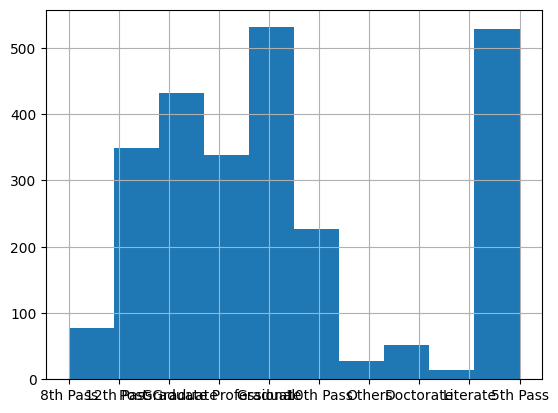

In [15]:
# ada = ADASYN(random_state=0, sampling_strategy={'8th Pass': 100, '12th Pass':352,  'Post Graduate':432, 'Graduate Professional':360, 'Graduate':550, '10th Pass':340,  'Others':28,  'Doctorate':250,  'Literate':200, '5th Pass':150})
ada = ADASYN(random_state=0, sampling_strategy="minority")
X_train_adasyn, y_train_adasyn = ada.fit_resample(X_train_preprocessed, y_train)

from collections import Counter
print('Before sampling class distribution:-',Counter(y_train))

print('New class distribution:-',Counter(y_train_adasyn))

print(X_train_adasyn)
y_train_adasyn.hist()

## Using SMOTE

In [77]:
smote = SVMSMOTE(sampling_strategy="all")

Before sampling class distribution:- Counter({'Graduate': 531, 'Post Graduate': 432, '12th Pass': 349, 'Graduate Professional': 339, '10th Pass': 227, '8th Pass': 78, 'Doctorate': 52, 'Others': 28, 'Literate': 14, '5th Pass': 9})
New class distribution:- Counter({'12th Pass': 531, 'Post Graduate': 531, 'Graduate': 531, 'Graduate Professional': 446, '10th Pass': 336, 'Doctorate': 315, 'Others': 303, '8th Pass': 259, '5th Pass': 240, 'Literate': 215})
[[ 0.46679808  4.05261459 -0.00776657 ...  0.          0.
   0.        ]
 [-0.37335686 -0.21457701 -0.10541735 ...  0.          0.
   0.        ]
 [-0.37335686 -0.09265725 -0.09467577 ...  0.          0.
   0.        ]
 ...
 [-0.37335686 -0.13138251 -0.09193917 ...  0.          0.
   0.        ]
 [-0.41637185  0.43614893  0.55048186 ...  1.          0.
   0.        ]
 [ 0.46679808  0.28890502  0.0921668  ...  0.          0.
   0.        ]]


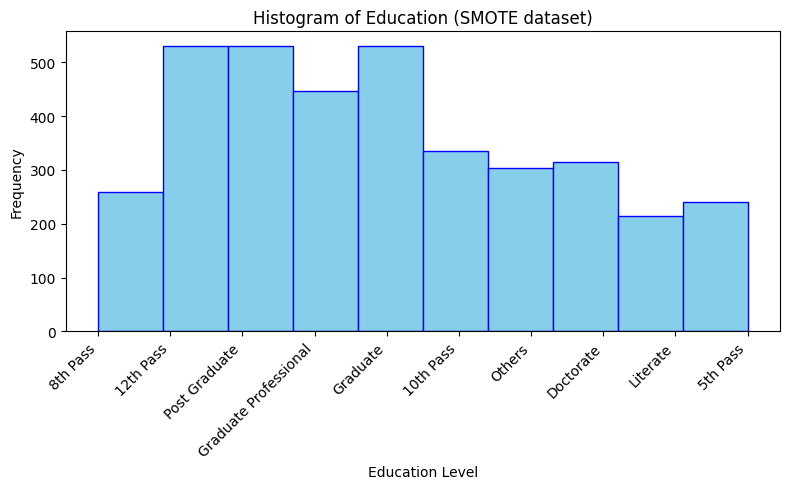

In [93]:
X_train_smote, y_train_smote = smote.fit_resample(X_train_preprocessed, y_train)
print('Before sampling class distribution:-',Counter(y_train))
print('New class distribution:-',Counter(y_train_smote))

print(X_train_smote)
plt.figure(figsize=(8, 5))
plt.hist(y_train_smote, color='skyblue', edgecolor='blue')
plt.title('Histogram of Education (SMOTE dataset)')
plt.xlabel('Education Level')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [24]:
# Training SVM on the SMOTE Dataset

sv = SVC(C = 7, kernel='rbf')
sv.fit(X_train_smote, y_train_smote)
X_test_preprocessed_smote = preprocessor.transform(X_testOG)
y4_smote = sv.predict(X_test_preprocessed_smote)

In [27]:
# Trying Bernoulli Naive Bayes

bnb = BernoulliNB()
bnb.fit(X_train_smote, y_train_smote)
y5 = bnb.predict(X_test_preprocessed_smote)

In [132]:
# kinda implementing gridsearch

CCC = [0.001, 0.01, 0.1, 1, 10, 100]

for c in CCC:
    sv_c = SVC(C = c, kernel='rbf')
    sv_c.fit(X_train_smote, y_train_smote)
    y4_smote_c = sv_c.predict(X_test_preprocessed_smote)
    y4_smote_c = pd.DataFrame(y4_smote_c)
    print(f1_score(y4_smote_c, final, average="micro"))

0.2692867540029112
0.2692867540029112
0.22852983988355166
0.24745269286754004
0.2765647743813683
0.2765647743813683


In [28]:
yxx = pd.DataFrame(ygg) 
yxx.to_csv('/kaggle/working/res1.csv',index=True)
yxx

,0
0,12th Pass
1,8th Pass
2,12th Pass
3,8th Pass
4,Post Graduate
...,...
1369,Doctorate
1370,Post Graduate
1371,Graduate
1372,Doctorate


## Data Visualization

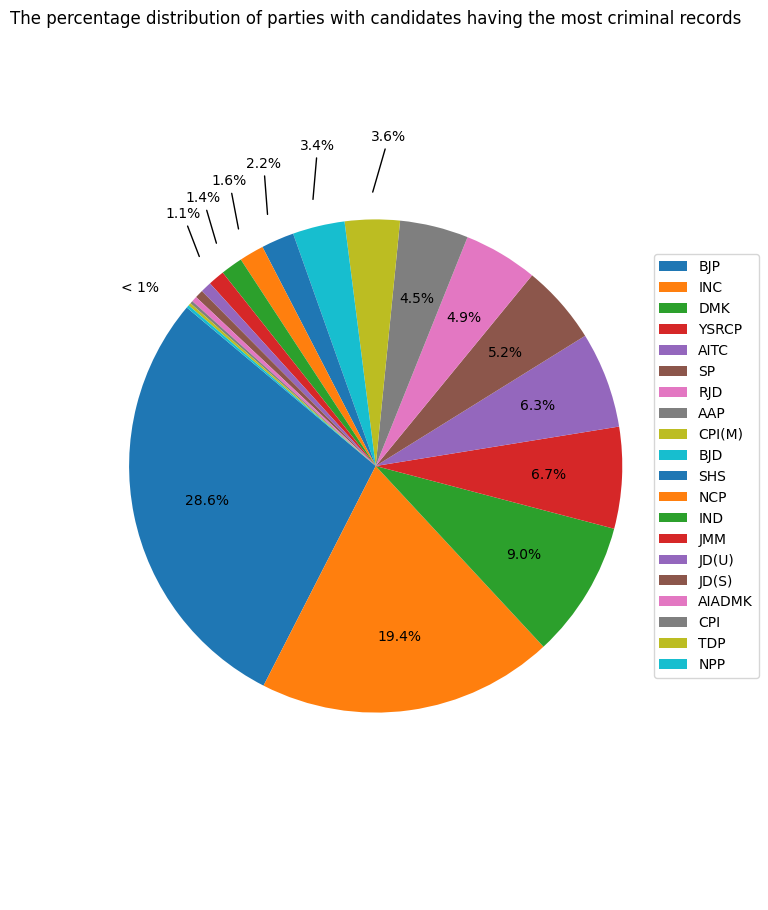

In [134]:
import numpy as np

df_sorted = train.sort_values(by='Criminal Case', ascending=False)

cutoff = df_sorted['Criminal Case'].quantile(0.8)
top_80_percentile = df_sorted[df_sorted['Criminal Case'] >= cutoff]
party_distribution = top_80_percentile['Party'].value_counts(normalize=True) * 100

plt.figure(figsize=(7, 7))
patches, texts, autotexts = plt.pie(party_distribution, autopct='%1.1f%%', startangle=140, pctdistance = 0.7)
plt.legend(party_distribution.index, loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('The percentage distribution of parties with candidates having the most criminal records')

for i, (patch, autotext) in enumerate(zip(patches, autotexts)):
        if float(autotext.get_text().strip('%')) < 4 and float(autotext.get_text().strip('%')) > 1:  
            angle = (patch.theta2 + patch.theta1) / 2
            x = patch.r * 1.1 * np.cos(angle * np.pi / 180)
            y = patch.r * 1.1 * np.sin(angle * np.pi / 180)
            plt.annotate(f"{autotext.get_text()}", (x, y), xytext=(1.2*x, 1.2*y), arrowprops=dict(arrowstyle="-", color='black'))
            
for autotext in autotexts:
    if float(autotext.get_text().strip('%')) < 4:
        autotext.set_text('')

plt.annotate(f"< 1%", ((1.1 * np.cos(200 * np.pi/180)), (1.1 * np.cos(310 * np.pi/180))))
plt.subplots_adjust(top=1.54, bottom=0.3)
plt.axis('equal')  
plt.show()

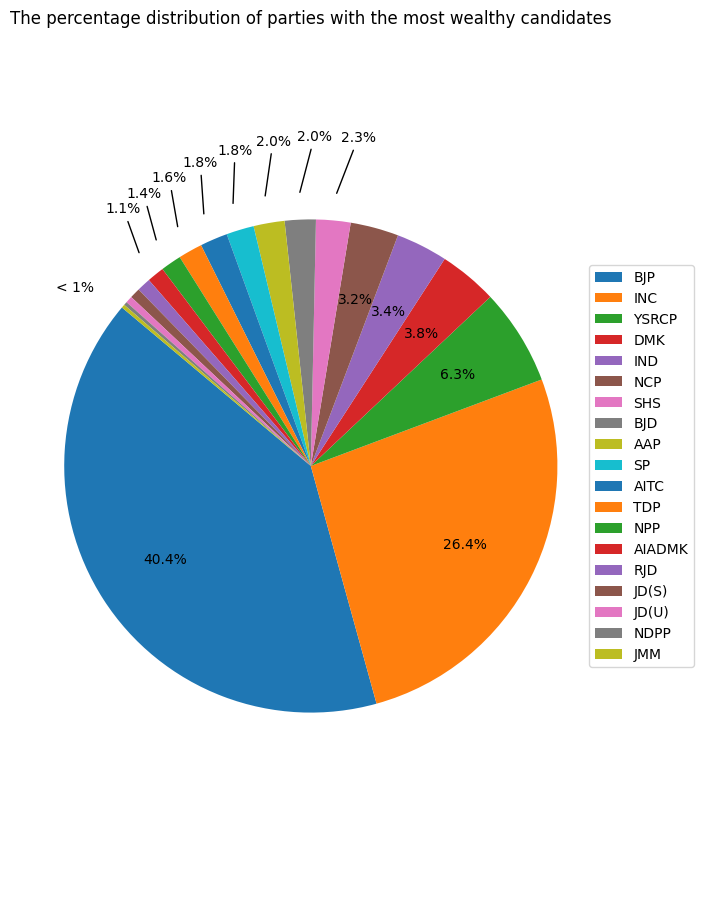

In [136]:
df_sorted2 = X.sort_values(by='Total Assets', ascending=False)
cutoff = df_sorted2['Total Assets'].quantile(0.8)
top_80_percentile = df_sorted2[df_sorted2['Total Assets'] >= cutoff]
party_distribution = top_80_percentile['Party'].value_counts(normalize=True) * 100

plt.figure(figsize=(7, 7))
patches, texts, autotexts = plt.pie(party_distribution, autopct='%1.1f%%', startangle=140, pctdistance = 0.7)
plt.legend(party_distribution.index, loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('')

for i, (patch, autotext) in enumerate(zip(patches, autotexts)):
        if float(autotext.get_text().strip('%')) < 3 and float(autotext.get_text().strip('%')) > 1: 
            angle = (patch.theta2 + patch.theta1) / 2
            x = patch.r * 1.1 * np.cos(angle * np.pi / 180)
            y = patch.r * 1.1 * np.sin(angle * np.pi / 180)
            plt.annotate(f"{autotext.get_text()}", (x, y), xytext=(1.2*x, 1.2*y), arrowprops=dict(arrowstyle="-", color='black'))
            
for autotext in autotexts:
    if float(autotext.get_text().strip('%')) < 3:
        autotext.set_text('')

plt.annotate(f"< 1%", ((1.1 * np.cos(200 * np.pi/180)), (1.1 * np.cos(310 * np.pi/180))))
plt.subplots_adjust(top=1.54, bottom=0.3)
plt.axis('equal') 
plt.show()

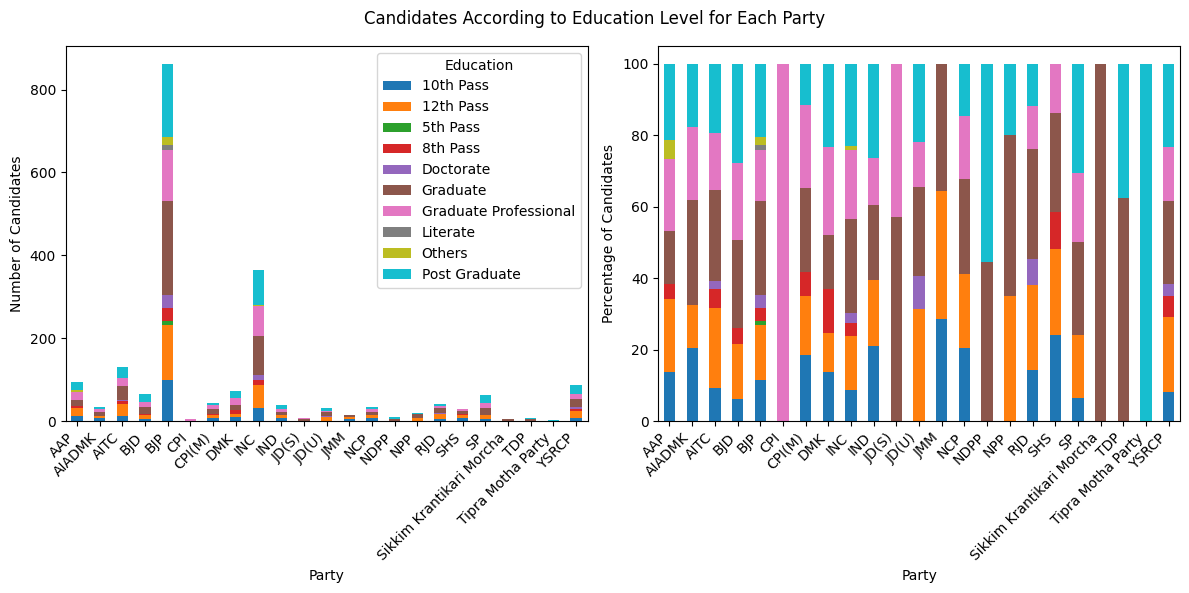

In [157]:
party_education_counts = train.groupby(['Party', 'Education']).size().unstack(fill_value=0)

plt.figure(figsize=(12, 6))
plt.suptitle('Candidates According to Education Level for Each Party')
plt.subplot(1, 2, 1)
party_education_counts.plot(kind='bar', stacked=True, ax=plt.gca())
plt.xlabel('Party')
plt.ylabel('Number of Candidates')
plt.xticks(rotation=45, ha='right')

plt.subplot(1, 2, 2)
party_education_percentages = party_education_counts.div(party_education_counts.sum(axis=1), axis=0) * 100
party_education_percentages.plot(kind='bar', stacked=True, ax=plt.gca(), legend=False)
plt.xlabel('Party')
plt.ylabel('Percentage of Candidates')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [4]:
train.nunique()

ID                2059
Candidate         2039
Constituency ∇    2037
Party               23
Criminal Case       35
Total Assets       210
Liabilities        170
state               28
Education           10
dtype: int64

In [97]:
print(y_train_smote.shape)

(3707,)


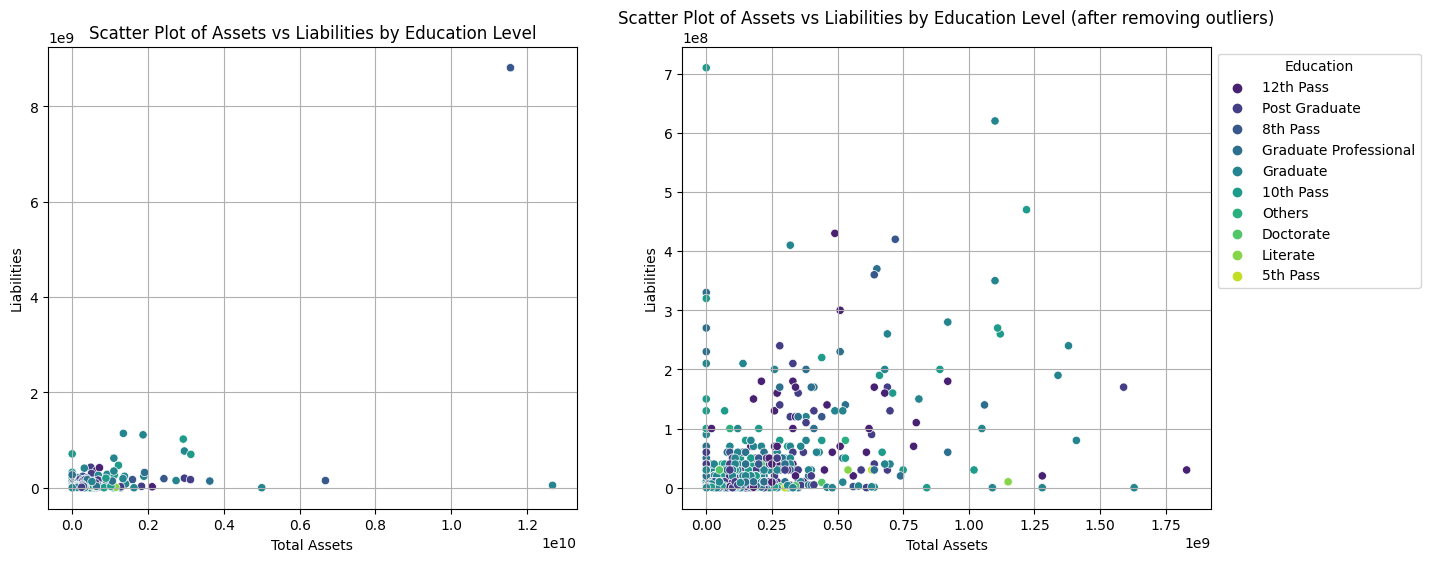

In [71]:
plt.figure(figsize=(15, 6))
plt.subplot(1,2,1)
sns.scatterplot(x='Total Assets', y='Liabilities', hue='Education', data=train, palette='viridis', legend=False)
plt.title('Scatter Plot of Assets vs Liabilities by Education Level')
plt.xlabel('Total Assets')
plt.ylabel('Liabilities')
plt.grid(True)

fildf = remove_outliers_zscore(train, 'A + L')

plt.subplot(1,2,2)                    
sns.scatterplot(x='Total Assets', y='Liabilities', hue='Education', data=fildf, palette='viridis')
plt.title('Scatter Plot of Assets vs Liabilities by Education Level (after removing outliers)')
plt.xlabel('Total Assets')
plt.ylabel('Liabilities')
plt.grid(True)
plt.legend(title='Education', bbox_to_anchor=(1, 1))
plt.show()

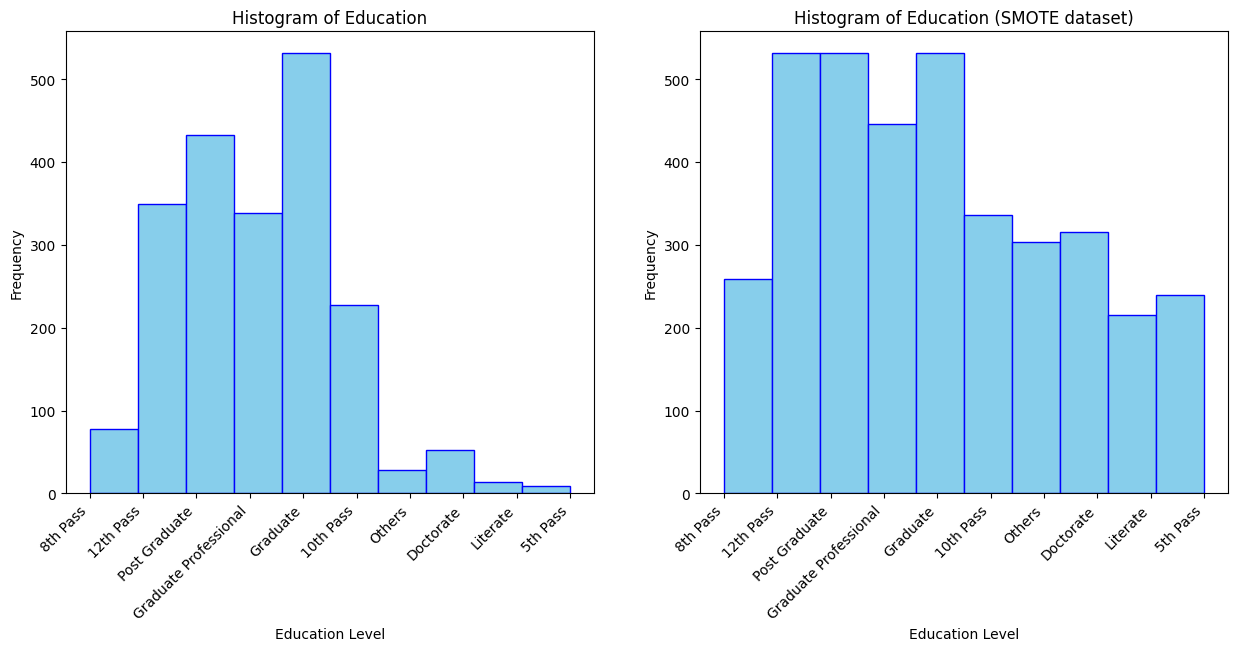

In [96]:
plt.figure(figsize=(15, 6))
plt.subplot(1,2,1)
plt.hist(train['Education'], color='skyblue', edgecolor='blue')
plt.title('Histogram of Education')
plt.xlabel('Education Level')
plt.ylabel('Frequency')

plt.xticks(rotation=45, ha='right')

plt.subplot(1,2,2)
plt.hist(y_train_smote, color='skyblue', edgecolor='blue')
plt.title('Histogram of Education (SMOTE dataset)')
plt.xlabel('Education Level')
plt.ylabel('Frequency')

plt.xticks(rotation=45, ha='right')

plt.show()


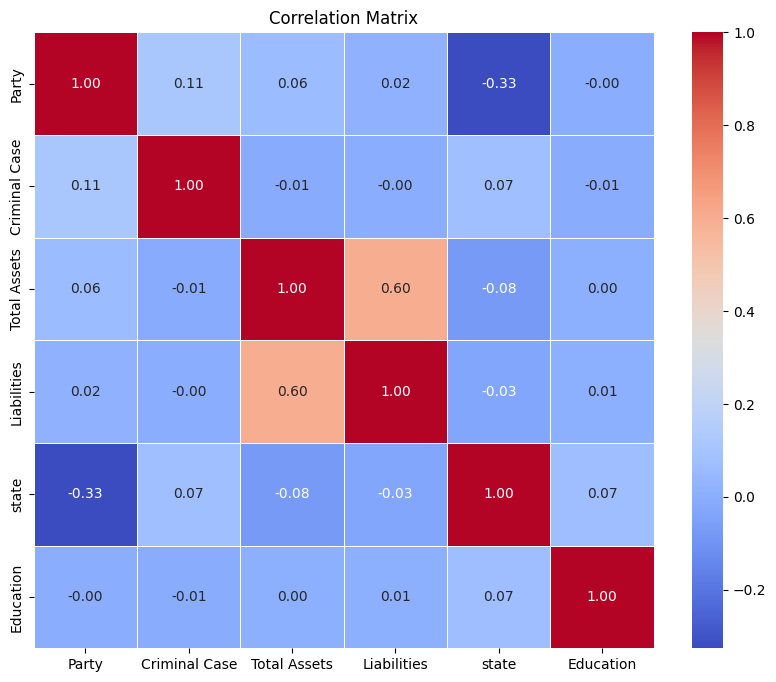

In [15]:
# Label Encoding just for plotting the correlation matrix

label_encoder = LabelEncoder()

train2 = train.drop(columns=['ID', 'Candidate', 'Constituency ∇'])

train2['Party'] = label_encoder.fit_transform(train2['Party'])
train2['state'] = label_encoder.fit_transform(train2['state'])
train2['Education'] = label_encoder.fit_transform(train2['Education'])

correlation_matrix = train2.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()